<a href="https://colab.research.google.com/github/dkanzariya/Computer-Vision/blob/main/SCAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/wvangansbeke/Unsupervised-Classification.git

Cloning into 'Unsupervised-Classification'...
remote: Enumerating objects: 166, done.
remote: Total 166 (delta 0), reused 0 (delta 0), pack-reused 166
Receiving objects: 100% (166/166), 13.41 MiB | 44.28 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
%cd Unsupervised-Classification/

/content/Unsupervised-Classification


In [ ]:
import argparse
import os
import torch
import numpy as np

pretrain_path = "/content/drive/MyDrive/SCAN/simclr_cifar-10.pth.tar"

state_dict = torch.load(pretrain_path,map_location=torch.device('cuda'))

from models.models import ContrastiveModel
from models.resnet_cifar import resnet18
backbone = resnet18()
model = ContrastiveModel(backbone,head='mlp',features_dim=128)
        # model = ContrastiveModel(backbone, **p['model_kwargs'])
model.load_state_dict(state_dict)
model.eval()

ContrastiveModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
len(train_dataloader), 97 * 512

(98, 49664)

In [ ]:
# from the train set lets get a embedding for each image  
from tqdm import tqdm

batch_size = 512

true_labels = []
images = np.zeros(((len(train_dataloader)-1) * batch_size,128))
model = model.cuda()
 
#get 500 images from train  
for i,data in tqdm(enumerate(train_dataloader)): 
    try: 
        if  i < len(train_dataloader)-1:  
            true_labels.extend(data['target'])
        images[i * batch_size : (i+1) * batch_size] = model(data['image'].cuda()).cpu().detach().numpy()
    except ValueError: 
        np.append(images,model(data['image'].cuda()).cpu().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
98it [00:10,  9.31it/s]


In [ ]:
images.shape,len(true_labels)

((49664, 128), 49664)

In [ ]:
#train kmeans 
from sklearn.cluster import KMeans 

kModel = KMeans(n_clusters = 10,n_jobs=-1,random_state = 101,max_iter = 1000,init = 'random',n_init=100)
 
# Training the model
kModel.fit(images)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=10, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [ ]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"classes : {classes}")

n_samples = 1000

kmeans_labels_dict = {}

for data in train_dataset:
       
    if classes == []:
      print("embedding for all classes found now stopping")
      break

    className = data['meta']['class_name']
   

    if className in classes: 
       
       embedding = model(data['image'].unsqueeze(0).cuda()).cpu().detach().numpy()
       
       kmeans_label = kModel.predict(embedding)
       
      #  print(f"Class Target : {data['target']}  Kmeans Target {kmeans_label} Class Name {className}")


       if kmeans_labels_dict.get(className,None) is None: 
          kmeans_labels_dict[className] = [kmeans_label[0]]
        
       else:
          kmeans_labels_dict[className].append(kmeans_label[0])
          
       # Here you can increase  
       if len(kmeans_labels_dict[className]) == n_samples:

          print(f'For  :: {className}  {kmeans_labels_dict[className]}') 
  
          classes.remove(className)

# kmeans_labels_dict

classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
For  :: bird  [7, 1, 2, 3, 1, 6, 7, 7, 2, 1, 9, 3, 9, 2, 7, 7, 9, 7, 8, 7, 2, 9, 1, 5, 7, 7, 8, 4, 5, 8, 3, 1, 2, 4, 8, 7, 7, 9, 4, 5, 7, 1, 3, 4, 9, 7, 7, 9, 8, 2, 9, 7, 8, 5, 2, 2, 1, 0, 9, 3, 7, 4, 9, 3, 2, 8, 7, 7, 9, 4, 7, 9, 7, 2, 0, 7, 7, 7, 2, 7, 8, 2, 7, 9, 0, 7, 9, 8, 8, 9, 2, 9, 3, 2, 2, 1, 1, 3, 2, 3, 7, 2, 7, 1, 7, 2, 9, 8, 9, 9, 1, 2, 0, 2, 5, 9, 7, 1, 2, 1, 3, 3, 2, 1, 9, 7, 7, 7, 4, 9, 1, 8, 5, 2, 9, 9, 3, 9, 7, 7, 9, 8, 9, 9, 1, 4, 9, 7, 7, 9, 4, 8, 2, 1, 2, 3, 4, 0, 7, 9, 7, 2, 3, 4, 3, 1, 2, 4, 2, 5, 4, 3, 2, 2, 9, 2, 2, 7, 9, 8, 4, 3, 2, 4, 8, 2, 9, 3, 7, 7, 7, 2, 8, 1, 2, 7, 4, 9, 4, 2, 2, 6, 7, 9, 0, 3, 2, 9, 2, 9, 2, 1, 4, 2, 7, 9, 4, 2, 2, 3, 7, 7, 2, 2, 7, 7, 8, 9, 1, 1, 7, 1, 3, 2, 4, 7, 1, 9, 3, 9, 8, 8, 8, 7, 8, 0, 7, 3, 2, 9, 9, 9, 2, 1, 9, 1, 2, 6, 2, 3, 3, 2, 2, 8, 7, 3, 1, 7, 3, 1, 9, 2, 2, 3, 9, 9, 8, 6, 2, 9, 9, 7, 8, 2, 7, 7, 2, 3, 9, 7, 1, 1, 6, 7, 1,

In [ ]:
import statistics 

mapping = {}

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

for i in kmeans_labels_dict:
  
  print(i , statistics.mode(kmeans_labels_dict[i]))

  mapping[statistics.mode(kmeans_labels_dict[i])] = classes.index(i)


frog 2
truck 2
deer 7
automobile 2
bird 9
horse 2
ship 2
cat 0
dog 0
airplane 5


In [ ]:
mapping 

{0: 5, 2: 8, 5: 0, 7: 4, 9: 2}

In [ ]:
from collections import Counter
for c_ in ['airplane','ship']:
  print(f'for {c_} most occuring  top 3 classes are : {Counter(kmeans_labels_dict[c_]).most_common(3)}')

# now the possiable classes for cat and dog are 

for airplane most occuring  top 3 classes are : [(5, 260), (8, 207), (2, 196)]
for ship most occuring  top 3 classes are : [(2, 202), (6, 184), (5, 165)]


In [ ]:
mapping[7] = classes.index('airplane')
mapping

{0: 5, 2: 8, 5: 0, 7: 0, 9: 2}

In [ ]:
#mapping 
preds = kModel.labels_
print("mapped for preds")
mapped_pred_labels = []

print(mapping)

print(len(preds))

for pred in preds: 
  mapped_pred_labels.append(mapping[pred]) 

len(mapped_pred_labels)

mapped for preds
{2: 8, 7: 0, 9: 2, 0: 5, 5: 0}
49664


KeyError: ignored

In [ ]:
true_labels[10:21],preds[10:21],mapped_pred_labels[10:21]

([tensor(4),
  tensor(7),
  tensor(7),
  tensor(2),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(3),
  tensor(2),
  tensor(6),
  tensor(4)],
 array([3, 8, 2, 1, 5, 6, 4, 0, 2, 0, 8], dtype=int32),
 [])

In [ ]:
# testing the accuracy with the real ground truth 
from sklearn.metrics import accuracy_score
accuracy_score(mapped_pred_labels,true_labels)

ValueError: ignored

In [ ]:
!python /content/Unsupervised-Classification/eval.py --config_exp /content/Unsupervised-Classification/configs/selflabel/selflabel_cifar10.yml --model /content/drive/MyDrive/SCAN/selflabel_cifar-10.pth.tar --visualize_prototypes

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18

state_dict = torch.load('/content/drive/MyDrive/SCAN/scan_cifar-10.pth.tar')

state_dict['model'].keys()

backbone = resnet18()
model = ClusteringModel(backbone, 10, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()

ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

for data in tqdm(train_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


In [ ]:
import pandas as pd 

'''
keys are the  preds and values are the gt. 

we will be mapping the preds to gt targets.

'''

df = pd.DataFrame(data_file)

gp = df.groupby('gt')

vals = gp.aggregate(statistics.mode).iloc[:,0:-1]

mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}

# for i,j in zip(list(vals.index),vals.values):

#   print(i,j)
mapping

{0: 6, 1: 0, 2: 8, 3: 9, 4: 4, 5: 5, 6: 7, 7: 1, 8: 2, 9: 3}

In [ ]:
df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    
accuracy_score(df['gt'].values,df['mapped_preds'].values)


0.82202

In [ ]:
from utils.common_config import get_val_dataset

#for evaluating will be only using the get_val_transforms
test_transformations = get_val_transformations(p)
test_dataset = get_val_dataset(p, test_transformations)
test_dataloader = torch.utils.data.DataLoader(test_dataset, num_workers=4,batch_size=512)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

# get preds 

for data in tqdm(test_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    


# create mapping 

df = pd.DataFrame(data_file)
gp = df.groupby('gt')
vals = gp.aggregate(statistics.mode).iloc[:,0:-1]
mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}
print('mappingn',mapping)


#mapping

df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    


print('test-acc :',accuracy_score(df['gt'].values,df['mapped_preds'].values))






  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 20/20 [00:02<00:00,  8.42it/s]

mappingn {1: 0, 7: 1, 8: 2, 9: 3, 4: 4, 5: 5, 0: 6, 6: 7, 2: 8, 3: 9}
test-acc : 0.8161


In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18


state_dict = torch.load('/content/drive/MyDrive/SCAN/selflabel_cifar-10.pth.tar')

# state_dict['model'].keys()

backbone = resnet18()
model = ClusteringModel(backbone, 10, 1)
model.load_state_dict(state_dict)
model = model.cuda()
model.eval()


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

for data in tqdm(train_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 98/98 [00:10<00:00,  9.71it/s]


In [ ]:
import pandas as pd 


df = pd.DataFrame(data_file)


gp = df.groupby('gt')


vals = gp.aggregate(statistics.mode).iloc[:,0:-1]


mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}

# for i,j in zip(list(vals.index),vals.values):

#   print(i,j)
mapping



'''
keys are the  preds and values are the gt. 

we will be mapping the preds to gt targets.

'''







df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    

accuracy_score(df['gt'].values,df['mapped_preds'].values)


0.88684

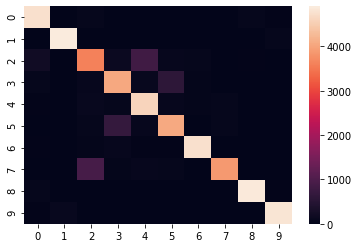

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns 

sns.heatmap(confusion_matrix(df['gt'].values,df['mapped_preds'].values))
